In [1]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


In [0]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    if(len(dataset) ==2):
        dataX.append(dataset[0])
        dataY.append(dataset[1,0])
        return np.array(dataX), np.array(dataY)
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
df = pd.read_csv("sp500.csv")
df['caldt'] = pd.to_datetime(df['caldt'], format = '%Y%m%d')
df['caldt'] =  df['caldt'].dt.strftime('%Y-%m-%d')
data = df['spindx'].values
data = data.astype('float32')
data = np.reshape(data,(-1,1))
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

df.head()

,caldt,vwretd,spindx,sprtrn
0,2009-06-01,0.025957,942.87,0.025818
1,2009-06-02,0.001893,944.74,0.001983
2,2009-06-03,-0.013036,931.76,-0.013739
3,2009-06-04,0.011331,942.46,0.011484
4,2009-06-05,-0.002298,940.09,-0.002515


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
# params
num_hidden = 4
pred = []
look_back = 1

start = time.time()
model = Sequential()
model.add(LSTM(num_hidden, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

train_split = 0.67
train_size = int(len(data) * train_split)
train, test = data[:train_size, :], data[train_size:, :]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX, testX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1])), testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)

testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
pred.append(testPredict)
end = time.time()





(1784, 1, 1) (878, 1, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





1784/1784 [==============================] - 14s 8ms/step - loss: 0.0113
Epoch 2/5
1784/1784 [==============================] - 12s 7ms/step - loss: 7.3005e-05
Epoch 3/5
1784/1784 [==============================] - 13s 7ms/step - loss: 6.4146e-05
Epoch 4/5
1784/1784 [==============================] - 13s 7ms/step - loss: 6.0215e-05
Epoch 5/5
1784/1784 [==============================] - 13s 7ms/step - loss: 5.3548e-05


In [6]:
print(end - start)

65.96998763084412


In [7]:
predictions = np.reshape(pred, (-1, 1))
print(testY.shape)
testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(testY.reshape((-1, 1))), predictions))
print('Test Score: %.2f RMSE' % (testScore))

(878,)
Test Score: 57.30 RMSE


(878, 1)


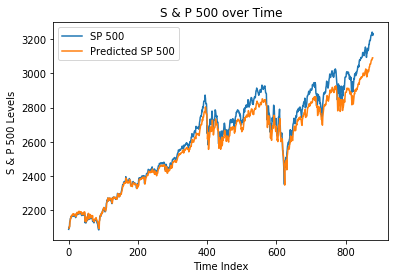

In [8]:
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
print(predictions.shape)
start_ind = train_size + look_back
testPredictPlot[start_ind : start_ind + len(predictions), :] = predictions
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data)[1786:], label = 'SP 500')
plt.plot(testPredictPlot[1786:], label = 'Predicted SP 500')
plt.ylabel('S & P 500 Levels')
plt.xlabel('Time Index')
plt.title('S & P 500 over Time')
plt.legend()
#plt.figure(figsize=(12,12))
#plt.show()
plt.savefig('sp500_plt_simplest.png')